# Negative L1 norm prior experiment

This code attempts to learn the 4D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_4D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 4

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 435.0282897949219
iteration 0 loss 491.01513671875


iteration 5000 loss 0.024604501202702522


iteration 10000 loss 0.015256205573678017


iteration 15000 loss 0.010823940858244896


iteration 20000 loss 0.008712539449334145


iteration 25000 loss 0.006270288955420256


iteration 30000 loss 0.005332798697054386


iteration 35000 loss 0.004543638322502375


iteration 40000 loss 0.003778807818889618


iteration 45000 loss 0.23014163970947266


iteration 50000 loss 0.0031143617816269398


iteration 55000 loss 0.002844643546268344


iteration 60000 loss 0.0026583781000226736


iteration 65000 loss 0.0024399696849286556


iteration 70000 loss 0.0022683488205075264


iteration 75000 loss 0.0021548019722104073


iteration 80000 loss 0.00211343914270401


iteration 85000 loss 0.0026046496350318193


iteration 90000 loss 0.0016086213290691376


iteration 95000 loss 0.0015036140102893114


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0013669438194483519


iteration 105000 loss 0.001292265485972166


iteration 110000 loss 0.0012009761994704604


iteration 115000 loss 0.0011277367593720555


iteration 120000 loss 0.0011931186309084296


iteration 125000 loss 0.0010147858411073685


iteration 130000 loss 0.0009679446811787784


iteration 135000 loss 0.000926450127735734


iteration 140000 loss 0.0009031321969814599


iteration 145000 loss 0.0008548328187316656


iteration 150000 loss 0.0008247373625636101


iteration 155000 loss 0.0007973535102792084


iteration 160000 loss 0.0007713644299656153


iteration 165000 loss 0.0007472040015272796


iteration 170000 loss 0.0007250794442370534


iteration 175000 loss 0.0008216981659643352


iteration 180000 loss 0.0006855919491499662


iteration 185000 loss 0.00066796486498788


iteration 190000 loss 0.0006509606610052288


iteration 195000 loss 0.0006352327181957662


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0006212303997017443


iteration 205000 loss 0.0006154751754365861


iteration 210000 loss 0.0006016448605805635


iteration 215000 loss 0.0005885858554393053


iteration 220000 loss 0.0005758742336183786


iteration 225000 loss 0.0005639941082336009


iteration 230000 loss 0.0005533258081413805


iteration 235000 loss 0.0005432185134850442


iteration 240000 loss 0.0005324436933733523


iteration 245000 loss 0.0005224888445809484


iteration 250000 loss 0.0005912204505875707


iteration 255000 loss 0.0005050411564297974


iteration 260000 loss 0.000495533284265548


iteration 265000 loss 0.00048655070713721216


iteration 270000 loss 0.00047832055133767426


iteration 275000 loss 0.0004698387929238379


iteration 280000 loss 0.0004624130961019546


iteration 285000 loss 0.0004548163269646466


iteration 290000 loss 0.0004471838765311986


iteration 295000 loss 0.00043925861245952547


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.00043157042819075286


iteration 305000 loss 0.0004280787252355367


iteration 310000 loss 0.0004206662124488503


iteration 315000 loss 0.00041334753041155636


iteration 320000 loss 0.00040632346644997597


iteration 325000 loss 0.00039945734897628427


iteration 330000 loss 0.0003933666739612818


iteration 335000 loss 0.0003872412198688835


iteration 340000 loss 0.00038136201328597963


iteration 345000 loss 0.00037594299647025764


iteration 350000 loss 0.00037062313640490174


iteration 355000 loss 0.00036544768954627216


iteration 360000 loss 0.0003601574862841517


iteration 365000 loss 0.0003555220609996468


iteration 370000 loss 0.0003507936780806631


iteration 375000 loss 0.000346138549502939


iteration 380000 loss 0.00034163115196861327


iteration 385000 loss 0.00033759826328605413


iteration 390000 loss 0.00033332471502944827


iteration 395000 loss 0.0003291240718681365


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.000325226312270388


iteration 405000 loss 0.00032417901093140244


iteration 410000 loss 0.00032255990663543344


iteration 415000 loss 0.00032098990050144494


iteration 420000 loss 0.0003194507153239101


iteration 425000 loss 0.00031793263042345643


iteration 430000 loss 0.00031643803231418133


iteration 435000 loss 0.00031496916199103


iteration 440000 loss 0.00031352363293990493


iteration 445000 loss 0.0003120947803836316


iteration 450000 loss 0.00031068501994013786


iteration 455000 loss 0.0003092910919804126


iteration 460000 loss 0.00030791116296313703


iteration 465000 loss 0.0003065458149649203


iteration 470000 loss 0.00030520244035869837


iteration 475000 loss 0.00030387387960217893


iteration 480000 loss 0.00030255751335062087


iteration 485000 loss 0.00030125569901429117


iteration 490000 loss 0.0002999659045599401


iteration 495000 loss 0.00029868734418414533


L2 loss -- Plot

loss 232.4912109375


loss 183.6964111328125


loss 155.8006591796875


loss 135.92140197753906


loss 123.77406311035156


loss 116.93609619140625


loss 113.1236572265625


loss 111.23388671875


loss 110.46192169189453


loss 110.20338439941406


loss 110.1353988647461


loss 110.12258911132812


loss 110.12104797363281


loss 110.12095642089844


loss 110.12095642089844


loss 110.12095642089844


loss 110.1209487915039


loss 110.12095642089844


loss 110.12095642089844


loss 110.12094116210938


loss 110.12095642089844


loss 110.12095642089844


loss 110.1209487915039


loss 110.12094116210938


loss 110.12095642089844


loss 110.12095642089844


loss 110.12095642089844


loss 110.12095642089844


loss 110.12095642089844


loss 110.12096405029297


loss 110.1209487915039


loss 110.1209487915039


loss 110.12095642089844


loss 110.12095642089844


loss 110.12095642089844


loss 110.12095642089844


loss 110.12095642089844


loss 110.12095642089844


loss 110.12095642089844


loss 110.12095642089844


final mse:  3.387556191114527e-08
max, min: 3.003343 -2.9969025
loss 232.4912109375


loss 183.94979858398438


loss 156.00732421875


loss 136.02713012695312


loss 123.91393280029297


loss 117.1085205078125


loss 113.35049438476562


loss 111.47578430175781


loss 110.69458770751953


loss 110.43338012695312


loss 110.3664321899414


loss 110.35421752929688


loss 110.35279846191406


loss 110.35270690917969


loss 110.35270690917969


loss 110.35270690917969


loss 110.35269927978516


loss 110.35270690917969


loss 110.35270690917969


loss 110.35270690917969


loss 110.35270690917969


loss 110.35269165039062


loss 110.35270690917969


loss 110.35270690917969


loss 110.35269927978516


loss 110.35270690917969


loss 110.35269165039062


loss 110.35270690917969


loss 110.35270690917969


loss 110.35269927978516


loss 110.35270690917969


loss 110.35270690917969


loss 110.35269165039062


loss 110.35270690917969


loss 110.35270690917969


loss 110.35269165039062


loss 110.35270690917969


loss 110.35270690917969


loss 110.35269927978516


loss 110.35270690917969


final mse:  2.7316534811916426e-08
max, min: 3.0008857 -2.9915004


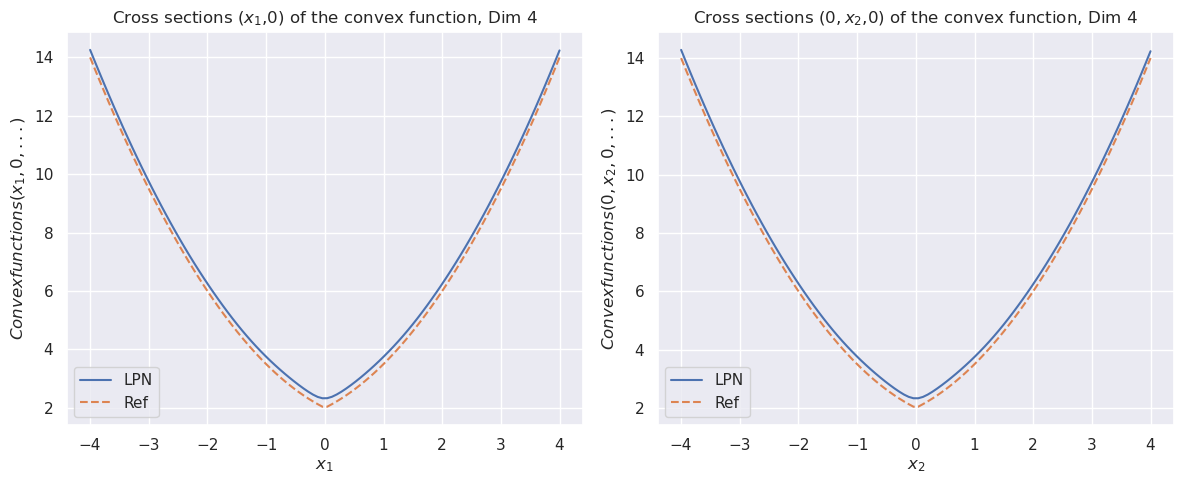

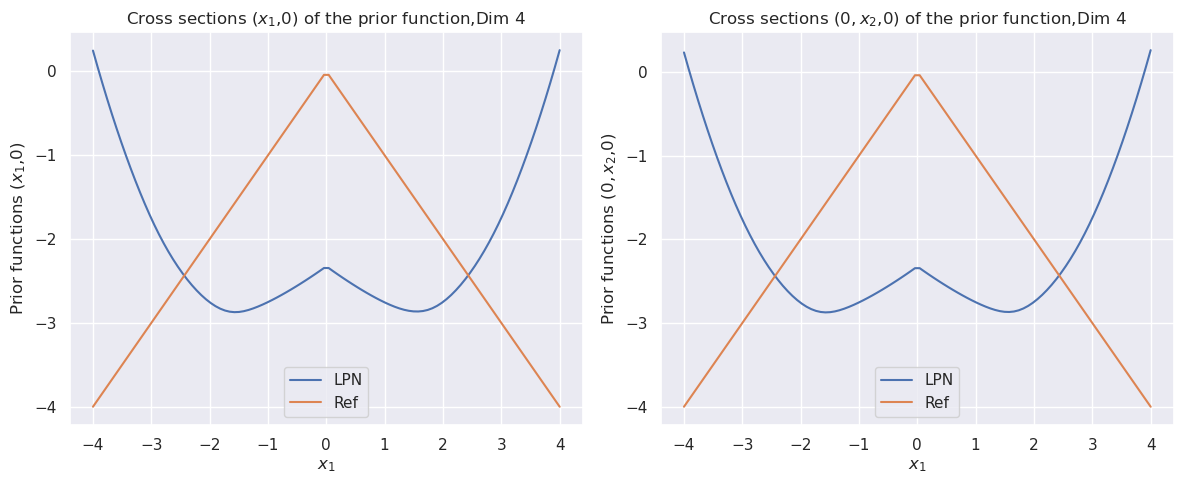

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 108.18928527832031
iteration 0 loss 2079.612548828125


iteration 5000 loss 0.03368791565299034


iteration 10000 loss 0.017712783068418503


iteration 15000 loss 0.007603767327964306


iteration 20000 loss 0.006490110419690609


iteration 25000 loss 0.005121184512972832


iteration 30000 loss 0.004090792965143919


iteration 35000 loss 0.003303283592686057


iteration 40000 loss 0.002613309770822525


iteration 45000 loss 0.0024617526214569807


iteration 50000 loss 0.002086172578856349


iteration 55000 loss 1.1714919805526733


iteration 60000 loss 0.0013142835814505816


iteration 65000 loss 0.0013509102864190936


iteration 70000 loss 0.0010774658294394612


iteration 75000 loss 0.0008463347912766039


iteration 80000 loss 0.0007897687028162181


iteration 85000 loss 0.0007117488421499729


iteration 90000 loss 0.0006021803710609674


iteration 95000 loss 0.0006869172211736441


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0004890451673418283


iteration 105000 loss 0.00043199825449846685


iteration 110000 loss 0.0003719569940585643


iteration 115000 loss 0.0003357968816999346


iteration 120000 loss 0.00029259579605422914


iteration 125000 loss 0.00026245613116770983


iteration 130000 loss 0.000238316337345168


iteration 135000 loss 0.00021642421779688448


iteration 140000 loss 0.00019844634516630322


iteration 145000 loss 0.00018313473265152425


iteration 150000 loss 0.0001685536844888702


iteration 155000 loss 0.0001558910880703479


iteration 160000 loss 0.00014496955554932356


iteration 165000 loss 0.0001351175451418385


iteration 170000 loss 0.00012649533164221793


iteration 175000 loss 0.00011892913607880473


iteration 180000 loss 0.00011214306141482666


iteration 185000 loss 0.0001059154819813557


iteration 190000 loss 0.00010051106801256537


iteration 195000 loss 0.00012312935723457485


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 9.064553887583315e-05


iteration 205000 loss 8.851868915371597e-05


iteration 210000 loss 8.409775182371959e-05


iteration 215000 loss 8.076953963609412e-05


iteration 220000 loss 7.710163481533527e-05


iteration 225000 loss 7.413868297589943e-05


iteration 230000 loss 7.114800973795354e-05


iteration 235000 loss 6.85596460243687e-05


iteration 240000 loss 6.604950613109395e-05


iteration 245000 loss 6.393999501597136e-05


iteration 250000 loss 6.195492460392416e-05


iteration 255000 loss 6.013472011545673e-05


iteration 260000 loss 5.850976594956592e-05


iteration 265000 loss 5.702823182218708e-05


iteration 270000 loss 5.557346230489202e-05


iteration 275000 loss 5.424389019026421e-05


iteration 280000 loss 5.2984152716817334e-05


iteration 285000 loss 5.178495484869927e-05


iteration 290000 loss 5.062749914941378e-05


iteration 295000 loss 4.9552290874999017e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 4.8550522478763014e-05


iteration 305000 loss 4.8312798753613606e-05


iteration 310000 loss 4.733915557153523e-05


iteration 315000 loss 4.6317625674419105e-05


iteration 320000 loss 4.5387132558971643e-05


iteration 325000 loss 4.461231583263725e-05


iteration 330000 loss 4.377183358883485e-05


iteration 335000 loss 4.307876224629581e-05


iteration 340000 loss 4.224082294967957e-05


iteration 345000 loss 4.152402834733948e-05


iteration 350000 loss 4.0871742385206744e-05


iteration 355000 loss 4.026406895718537e-05


iteration 360000 loss 3.9693466533208266e-05


iteration 365000 loss 3.907835343852639e-05


iteration 370000 loss 3.847458719974384e-05


iteration 375000 loss 3.798062607529573e-05


iteration 380000 loss 3.740618558367714e-05


iteration 385000 loss 3.685784395202063e-05


iteration 390000 loss 3.6347446439322084e-05


iteration 395000 loss 3.591197310015559e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.542508784448728e-05


iteration 405000 loss 3.536389340297319e-05


iteration 410000 loss 3.502362596918829e-05


iteration 415000 loss 3.4629207220859826e-05


iteration 420000 loss 3.4252723708050326e-05


iteration 425000 loss 3.388870391063392e-05


iteration 430000 loss 3.353495412738994e-05


iteration 435000 loss 3.319108873256482e-05


iteration 440000 loss 3.285549973952584e-05


iteration 445000 loss 3.2528383599128574e-05


iteration 450000 loss 3.2210151402978227e-05


iteration 455000 loss 3.189882409060374e-05


iteration 460000 loss 3.1594521715305746e-05


iteration 465000 loss 3.1296745873987675e-05


iteration 470000 loss 3.100526737398468e-05


iteration 475000 loss 3.0720031645614654e-05


iteration 480000 loss 3.044020377274137e-05


iteration 485000 loss 3.016508162545506e-05


iteration 490000 loss 2.9914715923951007e-05


iteration 495000 loss 2.9669114155694842e-05


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


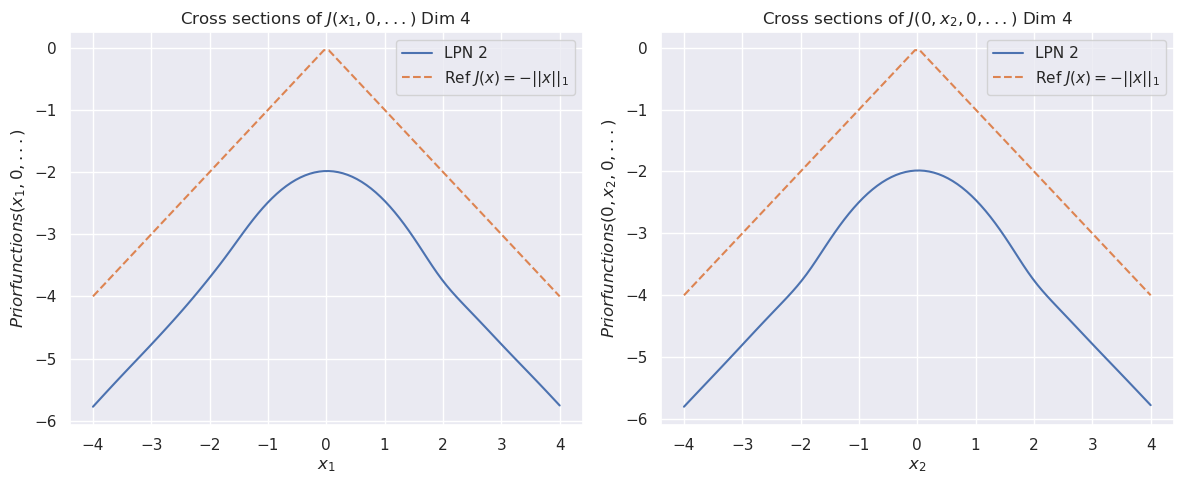

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)